In [22]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import minmax_scale
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import optuna
from sklearn.model_selection import train_test_split
import torch.optim.lr_scheduler as lr_scheduler

In [23]:
print(torch.cuda.is_available())
print(torch.version.cuda)
plt.ion()
plt.isinteractive()

False
None


True

In [24]:
data = pd.read_pickle('dataset.pkl')
print(data.shape, data.shape[0]==1615) # 1615 is mentioned in paper
data.head()

(1615, 63) True


SubjID Foot  TimeStampKin  TimeStampGrf  TimeStampEmg     Task  \
0  Subject37   RX      2.233333      2.233333      2.233333  Walking   
1  Subject37   RX      2.566667      2.566667      2.566667  Walking   
2  Subject37   RX      3.166667      3.170833      3.166667  Walking   
3  Subject37   RX      2.550000      2.551042      2.550000  Walking   
4  Subject37   RX      2.900000      2.900000      2.900000  Walking   

                                              Marker     speed  strideLength  \
0  [[-0.033561501652002335, -0.002794323256239295...  1.837413      1.631730   
1  [[-0.057129260152578354, -0.027161534875631332...  1.805230      1.642216   
2  [[-0.06355983763933182, -0.04139001667499542, ...  1.312175      1.344862   
3  [[-0.03138355538249016, -0.009803356602787971,...  1.309212      1.376798   
4  [[0.012496327981352806, 0.03410758078098297, 0...  1.359802      1.436055   

   stepWidth  ...                                       Pwr_AnklePwr  \
0   0.107636  ...  [0.004778790753334761, 0.009658068125136208, 0...   
1   0.093861  ...  [-0.030399857088923454, -0.0355768306180834, -...   
2   0.080773  ...  [-0.025188179686665535, -0.032375372294336714,...   
3   0.095240  ...  [-0.041394226253032684, -0.041821013540029525,...   
4   0.092319  ...  [-0.0336473323404789, -0.03586967594921587, -0...   

        name Age Gender   BH  BM KinFreq GrfFreq EMGFreq EMGSide  
0  Subject37  13      F  161  47      60     960     960     RX   
1  Subject37  13      F  161  47      60     960     960     RX   
2  Subject37  13      F  161  47      60     960     960     RX   
3  Subject37  13      F  161  47      60     960     960     RX   
4  Subject37  13      F  161  47      60     960     960     RX   

[5 rows x 63 columns]

In [25]:
info_columns = ['SubjID', 'Gender', 'Age', 'BH', 'BM']

data['EMGSide'] = data['EMGSide'].apply(lambda x:x.strip())
data = data.drop(index=data[data['EMGSide']=='NO'].index)
data['Gender'] = data['Gender'].apply(lambda x:x.upper())
data.rename(columns={c:c.replace(' ','_') for c in data.columns if 'Emg_' in c}, inplace=True)

In [26]:
selected_task = 'Walking' # 'StepUp'
idx_task = (data['Task'] == selected_task)
idx_dataside = (data['Foot'] == 'RX' ) & (data['EMGSide'] == 'RX' )
idx_bmi = (data['BM']/(data['BH']/100)**2>18.5) & (data['BM']/(data['BH']/100)**2<25)
#idx_age = (data['Age']>18) & (data['Age'] < 65)
idx_age = data['Age']>0
idx = idx_task & idx_dataside & idx_age #& idx_bmi
data_selected = data[idx]

# rm_subjs = ['Subject35','Subject24','Subject12']
# rm_subjs = ['Subject10','Subject23','Subject26']
# data_selected = data_selected[~data_selected.SubjID.isin(rm_subjs)]

df_tmp = data_selected['SubjID'].value_counts()
rm_subjs = df_tmp[df_tmp < 3].index
print('Del:', rm_subjs)
data_selected = data_selected[~data_selected.SubjID.isin(rm_subjs)]
print('Num of Subj:', len(data_selected.SubjID.unique()))

data_selected

Del: Index(['Subject29', 'Subject36'], dtype='object')
Num of Subj: 47


SubjID Foot  TimeStampKin  TimeStampGrf  TimeStampEmg     Task  \
0     Subject37   RX      2.233333      2.233333      2.233333  Walking   
1     Subject37   RX      2.566667      2.566667      2.566667  Walking   
2     Subject37   RX      3.166667      3.170833      3.166667  Walking   
3     Subject37   RX      2.550000      2.551042      2.550000  Walking   
4     Subject37   RX      2.900000      2.900000      2.900000  Walking   
...         ...  ...           ...           ...           ...      ...   
1596  Subject12   RX      5.525000      5.525000      5.525000  Walking   
1597  Subject12   RX      4.450000      4.450000      4.450000  Walking   
1598  Subject12   RX      3.450000      3.450000      3.450000  Walking   
1599  Subject12   RX      4.675000      4.675000      4.675000  Walking   
1600  Subject12   RX      5.000000      5.000000      5.000000  Walking   

                                                 Marker     speed  \
0     [[-0.033561501652002335, -0.002794323256239295...  1.837413   
1     [[-0.057129260152578354, -0.027161534875631332...  1.805230   
2     [[-0.06355983763933182, -0.04139001667499542, ...  1.312175   
3     [[-0.03138355538249016, -0.009803356602787971,...  1.309212   
4     [[0.012496327981352806, 0.03410758078098297, 0...  1.359802   
...                                                 ...       ...   
1596  [[0.6068676114082336, 0.6103021752955262, 0.61...  0.696277   
1597  [[0.693151593208313, 0.6975292934722404, 0.701...  0.814231   
1598  [[0.04064056649804115, 0.04417061295352771, 0....  0.813239   
1599  [[-0.07035181671380997, -0.06690458315256438, ...  0.619123   
1600  [[-0.14180660247802734, -0.138288067960081, -0...  0.606610   

      strideLength  stepWidth  ...  \
0         1.631730   0.107636  ...   
1         1.642216   0.093861  ...   
2         1.344862   0.080773  ...   
3         1.376798   0.095240  ...   
4         1.436055   0.092319  ...   
...            ...        ...  ...   
1596      1.005183   0.097058  ...   
1597      1.058802   0.117548  ...   
1598      1.079761   0.111373  ...   
1599      0.929500   0.121616  ...   
1600      0.961596   0.112472  ...   

                                           Pwr_AnklePwr       name Age Gender  \
0     [0.004778790753334761, 0.009658068125136208, 0...  Subject37  13      F   
1     [-0.030399857088923454, -0.0355768306180834, -...  Subject37  13      F   
2     [-0.025188179686665535, -0.032375372294336714,...  Subject37  13      F   
3     [-0.041394226253032684, -0.041821013540029525,...  Subject37  13      F   
4     [-0.0336473323404789, -0.03586967594921587, -0...  Subject37  13      F   
...                                                 ...        ...  ..    ...   
1596  [0.008009789511561394, 0.011878301603719546, 0...  Subject12  26      F   
1597  [-0.011530614458024502, -0.002087467811070551,...  Subject12  26      F   
1598  [-0.02502705529332161, -0.023969287183135745, ...  Subject12  26      F   
1599  [-0.008315440267324448, -0.004934047693386649,...  Subject12  26      F   
1600  [-0.005861234851181507, -0.002311035472666814,...  Subject12  26      F   

       BH  BM KinFreq GrfFreq EMGFreq EMGSide  
0     161  47      60     960     960      RX  
1     161  47      60     960     960      RX  
2     161  47      60     960     960      RX  
3     161  47      60     960     960      RX  
4     161  47      60     960     960      RX  
...   ...  ..     ...     ...     ...     ...  
1596  166  54     200     800     800      RX  
1597  166  54     200     800     800      RX  
1598  166  54     200     800     800      RX  
1599  166  54     200     800     800      RX  
1600  166  54     200     800     800      RX  

[568 rows x 63 columns]

Age          BH          BM
count  568.000000  568.000000  568.000000
mean    28.985915  162.172535   57.596831
std     18.130231   19.259075   18.709921
min      6.000000  117.000000   18.000000
25%     13.000000  155.000000   50.000000
50%     27.000000  166.000000   58.000000
75%     37.000000  180.000000   70.000000
max     72.000000  188.000000  110.000000

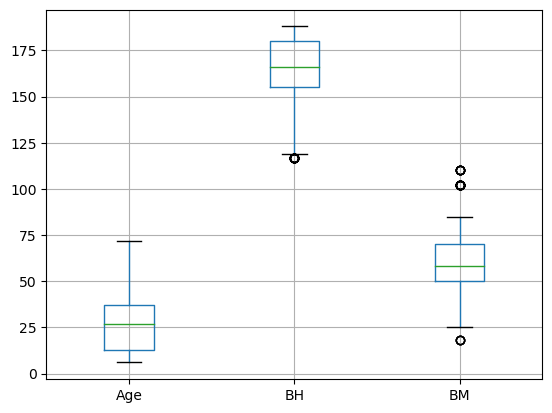

In [27]:
data_selected[info_columns].boxplot()
data_selected[info_columns].describe()

In [28]:
def get_outliers(data1, col):
    # finding the 1st quartile
    q1 = np.quantile(data1[col], 0.25)
     
    # finding the 3rd quartile
    q3 = np.quantile(data1[col], 0.75)
    med = np.median(data1[col])
     
    # finding the iqr region
    iqr = q3-q1
     
    # finding upper and lower whiskers
    upper_bound = q3+(1.5*iqr)
    lower_bound = q1-(1.5*iqr)
    
    return data_selected[(data1[col]>upper_bound)|(data1[col]<lower_bound)]['SubjID'].unique().tolist()

outlier_subjs = set(get_outliers(data_selected,'BH')+get_outliers(data_selected,'BM')+get_outliers(data_selected,'Age'))
outlier_subjs

{'Subject19', 'Subject25', 'Subject3', 'Subject40', 'Subject43'}

In [29]:
print('Num of Subj:', len(data_selected.SubjID.unique()))
data_selected = data_selected[~data_selected.SubjID.isin(outlier_subjs)]
print('Num of Subj:', len(data_selected.SubjID.unique()))

Num of Subj: 47
Num of Subj: 42


In [30]:
def filteremg(emg, low_pass=10, sfreq=1000, high_band=10, low_band=450):
    """
    emg: EMG data
    high: high-pass cut off frequency
    low: low-pass cut off frequency
    sfreq: sampling frequency
    """
    
    # normalise cut-off frequencies to sampling frequency
    high_band = high_band/(sfreq/2)
    low_band = low_band/(sfreq/2)
    
    # create bandpass filter for EMG
    b1, a1 = signal.butter(4, [high_band,low_band], btype='bandpass')
    
    # process EMG signal: filter EMG
    emg_filtered = signal.filtfilt(b1, a1, emg)    
    
    # process EMG signal: rectify
    emg_rectified = abs(emg_filtered)
    
    # create lowpass filter and apply to rectified signal to get EMG envelope
    low_pass = low_pass/(sfreq/2)
    b2, a2 = signal.butter(4, low_pass, btype='lowpass')
    emg_envelope = signal.filtfilt(b2, a2, emg_rectified)

    return emg_envelope

def moving_average(data_, window_size):
    window = np.ones(window_size) / window_size
    smoothed_data = signal.convolve(data_, window, mode='same')
    return smoothed_data

def preprocess_grf(y_, window_width_, samples_decimated_):
    # abs
    # y_ = np.abs(y_)

    # moving average
    cumsum_vec = np.cumsum(y_)
    y_ma = (cumsum_vec[window_width_:] - cumsum_vec[:-window_width_]) / window_width_

    # resample
    y_resampled_ = signal.resample(y_ma, samples_decimated_)

    # scale
    scaling = False
    if scaling:
        y_resampled_ = minmax_scale(y_resampled_, feature_range=(0, 1), axis=0, copy=True)

    return y_resampled_


In [35]:
pd.set_option('mode.chained_assignment', None)

emg_cols = [c for c in data_selected.columns if (('Emg_' in c) and not('_filtered' in c))]
for c in emg_cols:
    data_selected[c+'_filtered'] = data_selected.apply(lambda x: filteremg(emg=x[c], low_pass=10, sfreq=x.EMGFreq, high_band=5, low_band=399), axis=1)

emg_cols_filtered = [c+'_filtered' for c in emg_cols]
for c in emg_cols_filtered:
    data_selected[c+'_resampled'] = data_selected.apply(lambda x: signal.resample(x[c], 101), axis=1)

emg_cols_resampled = [c+'_resampled' for c in emg_cols_filtered]
for c in emg_cols_resampled:
    data_selected[c+'_scaled'] = data_selected.apply(lambda x: minmax_scale(x[c], feature_range=(0, 1)), axis=1)

pd.set_option('mode.chained_assignment', 'warn')

In [37]:
pd.set_option('mode.chained_assignment', None)

grf_cols = [c for c in data_selected.columns if (('Grf_GRFF' in c) and not('_filtered' in c))]
for c in grf_cols:
    data_selected[c] = data_selected[c]/data_selected['BM']

for c in grf_cols:
    data_selected[c+'_filtered'] = data_selected.apply(lambda x: moving_average(x[c], window_size=30), axis=1)

grf_cols_filtered = [c+'_filtered' for c in grf_cols]
for c in grf_cols_filtered:
    data_selected[c+'_resampled'] = data_selected.apply(lambda x: signal.resample(x[c], 101), axis=1)

grf_cols_resampled = [c+'_resampled' for c in grf_cols_filtered]
for c in grf_cols_resampled:
    data_selected[c+'_scaled'] = data_selected.apply(lambda x: minmax_scale(x[c], feature_range=(0, 1)), axis=1)

pd.set_option('mode.chained_assignment', 'warn')

In [38]:
pd.set_option('mode.chained_assignment', None)

ang_cols = [c for c in data_selected.columns if 'Ang_Ankle' in c] \
           + [c for c in data_selected.columns if 'Ang_Knee' in c] \
           + [c for c in data_selected.columns if 'Ang_Hip' in c]

for c in ang_cols:
    data_selected[c+'_scaled'] = data_selected.apply(lambda x: minmax_scale(x[c], feature_range=(0, 1)), axis=1)

pd.set_option('mode.chained_assignment', 'warn')

In [39]:
emg_cols = [c for c in data_selected.columns if (('Emg_' in c) and ('_scaled' in c))]
ang_cols = [c for c in data_selected.columns if (('Ang_Ankle' in c) and ('_scaled' in c))] \
           + [c for c in data_selected.columns if (('Ang_Knee' in c) and ('_scaled' in c))] \
           + [c for c in data_selected.columns if (('Ang_Hip' in c) and ('_scaled' in c))]
# mom_cols = [c for c in data_selected.columns if 'Mom_Ankle' in c] \
#            + [c for c in data_selected.columns if 'Mom_Knee' in c] \
#            + [c for c in data_selected.columns if 'Mom_Hip' in c]
grf_cols = [c for c in data_selected.columns if (('Grf_GRFF' in c) and ('_scaled' in c))]
#ang_cols = [c for c in data_selected.columns if 'Ang_AnkleFlx' in c]
#mom_cols = [c for c in data_selected.columns if 'Mom_AnkleFlx' in c]
check_outlier_cols = emg_cols + ang_cols + grf_cols
check_outlier_cols

['Emg_Tibialis_Anterior_filtered_resampled_scaled',
 'Emg_Soleus_filtered_resampled_scaled',
 'Emg_Gastrocnemius_Medialis_filtered_resampled_scaled',
 'Emg_Peroneus_Longus_filtered_resampled_scaled',
 'Emg_Rectus_Femoris_filtered_resampled_scaled',
 'Emg_Vastus_Medialis_filtered_resampled_scaled',
 'Emg_Biceps_Femoris_filtered_resampled_scaled',
 'Emg_Gluteus_Maximus_filtered_resampled_scaled',
 'Ang_AnkleFlx_scaled',
 'Ang_AnkleAdd_scaled',
 'Ang_AnkleRot_scaled',
 'Ang_KneeFlx_scaled',
 'Ang_KneeAdd_scaled',
 'Ang_KneeRot_scaled',
 'Ang_HipFlx_scaled',
 'Ang_HipAdd_scaled',
 'Ang_HipRot_scaled',
 'Grf_GRFF_X_filtered_resampled_scaled',
 'Grf_GRFF_Y_filtered_resampled_scaled',
 'Grf_GRFF_Z_filtered_resampled_scaled']

In [48]:
df_outlier_check = data_selected[info_columns]#.reset_index(drop=True)
df_stats = pd.DataFrame(index=check_outlier_cols, columns=['mean','std'])
for check_col in check_outlier_cols:
    df_tmp = pd.DataFrame(columns=range(0,101))
    for i in range(0,data_selected.shape[0]):
        df_tmp.loc[i,:] = data_selected.iloc[i][check_col]

    smooth_path    = df_tmp.mean(axis=0).astype(float)
    path_deviation = df_tmp.std(axis=0).astype(float)
    standard_deviations = 3

    num_of_outliers = df_tmp.T.apply(lambda x: np.abs((x-smooth_path)/path_deviation)>standard_deviations).sum(axis=0)
    num_of_outliers.index = df_outlier_check.index
    df_outlier_check[check_col] = num_of_outliers

    corr_with_mean = df_tmp.T.apply(lambda x: np.corrcoef(smooth_path.astype(float), x.astype(float))[0,1])
    corr_with_mean.index = df_outlier_check.index
    df_outlier_check[check_col+'_corr'] = corr_with_mean

    df_stats.loc[check_col,'mean'] = [smooth_path]
    df_stats.loc[check_col,'std'] = [path_deviation]

df_outlier_check

/var/folders/47/z8z3h1z942n3z28kv7czk7640000gn/T/ipykernel_26727/1016471338.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier_check[check_col] = num_of_outliers
/var/folders/47/z8z3h1z942n3z28kv7czk7640000gn/T/ipykernel_26727/1016471338.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier_check[check_col+'_corr'] = corr_with_mean
/var/folders/47/z8z3h1z942n3z28kv7czk7640000gn/T/ipykernel_26727/1016471338.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

SubjID Gender  Age   BH  BM  \
0     Subject37      F   13  161  47   
1     Subject37      F   13  161  47   
2     Subject37      F   13  161  47   
3     Subject37      F   13  161  47   
4     Subject37      F   13  161  47   
...         ...    ...  ...  ...  ..   
1596  Subject12      F   26  166  54   
1597  Subject12      F   26  166  54   
1598  Subject12      F   26  166  54   
1599  Subject12      F   26  166  54   
1600  Subject12      F   26  166  54   

      Emg_Tibialis_Anterior_filtered_resampled_scaled  \
0                                                   6   
1                                                   0   
2                                                   0   
3                                                   0   
4                                                   0   
...                                               ...   
1596                                                0   
1597                                                0   
1598                                                0   
1599                                                1   
1600                                                0   

      Emg_Tibialis_Anterior_filtered_resampled_scaled_corr  \
0                                              0.566040      
1                                              0.750135      
2                                              0.893513      
3                                              0.907169      
4                                              0.832240      
...                                                 ...      
1596                                           0.723171      
1597                                           0.794417      
1598                                           0.820108      
1599                                           0.618168      
1600                                           0.755087      

      Emg_Soleus_filtered_resampled_scaled  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
1596                                     0   
1597                                     0   
1598                                     0   
1599                                     0   
1600                                     0   

      Emg_Soleus_filtered_resampled_scaled_corr  \
0                                      0.829215   
1                                      0.904871   
2                                      0.917130   
3                                      0.949619   
4                                      0.912837   
...                                         ...   
1596                                   0.824647   
1597                                   0.868705   
1598                                   0.911477   
1599                                   0.727108   
1600                                   0.879956   

      Emg_Gastrocnemius_Medialis_filtered_resampled_scaled  ...  \
0                                                     0     ...   
1                                                     0     ...   
2                                                     0     ...   
3                                                     0     ...   
4                                                     0     ...   
...                                                 ...     ...   
1596                                                  0     ...   
1597                                                  0     ...   
1598                                                  0     ...   
1599                                                  0     ...   
1600                                                  0     ...   

      Ang_HipAdd_scaled  Ang_HipAdd_scaled_corr  Ang_HipRot_scaled  \
0                     0                0.783622          

In [88]:
num_of_point_exceed_thr = 10

# get index for any of column has higher number of outlier than thr
outlier_idx = df_outlier_check[(df_outlier_check[check_outlier_cols]>num_of_point_exceed_thr).any(axis=1)].index.tolist()

# calculate value counts for each subject
df_outlier_check_val_cnt = pd.DataFrame(df_outlier_check.SubjID.value_counts().rename('cnt')).join(
    df_outlier_check[(df_outlier_check.index.isin(outlier_idx))].SubjID.value_counts().rename('rm_cnt')).fillna(0)
df_outlier_check_val_cnt['remained'] = df_outlier_check_val_cnt.cnt - df_outlier_check_val_cnt.rm_cnt
df_temp = df_outlier_check[info_columns].drop_duplicates()
df_temp.index = df_temp.SubjID
df_outlier_check_val_cnt = df_outlier_check_val_cnt.join(df_temp)

# check if each subject has at least 5 trial after removing
outlier_subjid = df_outlier_check_val_cnt[df_outlier_check_val_cnt['remained']<5].index.to_list()

outlier_idx = outlier_idx + df_outlier_check[df_outlier_check.SubjID.isin(outlier_subjid)].index.tolist()
df_outlier_check['isOutlier'] = df_outlier_check.index.isin(outlier_idx)*1

print(len(df_outlier_check.SubjID.unique()), len(df_outlier_check[df_outlier_check['isOutlier']==0].SubjID.unique()))
print(len(df_outlier_check), sum(df_outlier_check['isOutlier']==0))

42 33
511 304


/var/folders/47/z8z3h1z942n3z28kv7czk7640000gn/T/ipykernel_26727/2549762488.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier_check['isOutlier'] = df_outlier_check.index.isin(outlier_idx)*1


In [89]:
data_selected_clean = data_selected[~(data_selected.index.isin(outlier_idx))]
data_selected_clean.shape

(304, 105)

In [94]:
df_outlier_check_val_cnt[df_outlier_check_val_cnt.remained<5]

cnt  rm_cnt  remained     SubjID Gender  Age   BH  BM
Subject30   15    12.0       3.0  Subject30      F    9  135  33
Subject23   14    10.0       4.0  Subject23      F   72  157  64
Subject26   14    13.0       1.0  Subject26      F   14  158  50
Subject45   13     9.0       4.0  Subject45      M   10  126  25
Subject41   12     8.0       4.0  Subject41      F    8  131  25
Subject13   10     8.0       2.0  Subject13      F   27  160  68
Subject34    8     5.0       3.0  Subject34      M   10  144  40
Subject49    5     2.0       3.0  Subject49      M   38  184  85
Subject47    5     5.0       0.0  Subject47      F   36  167  63

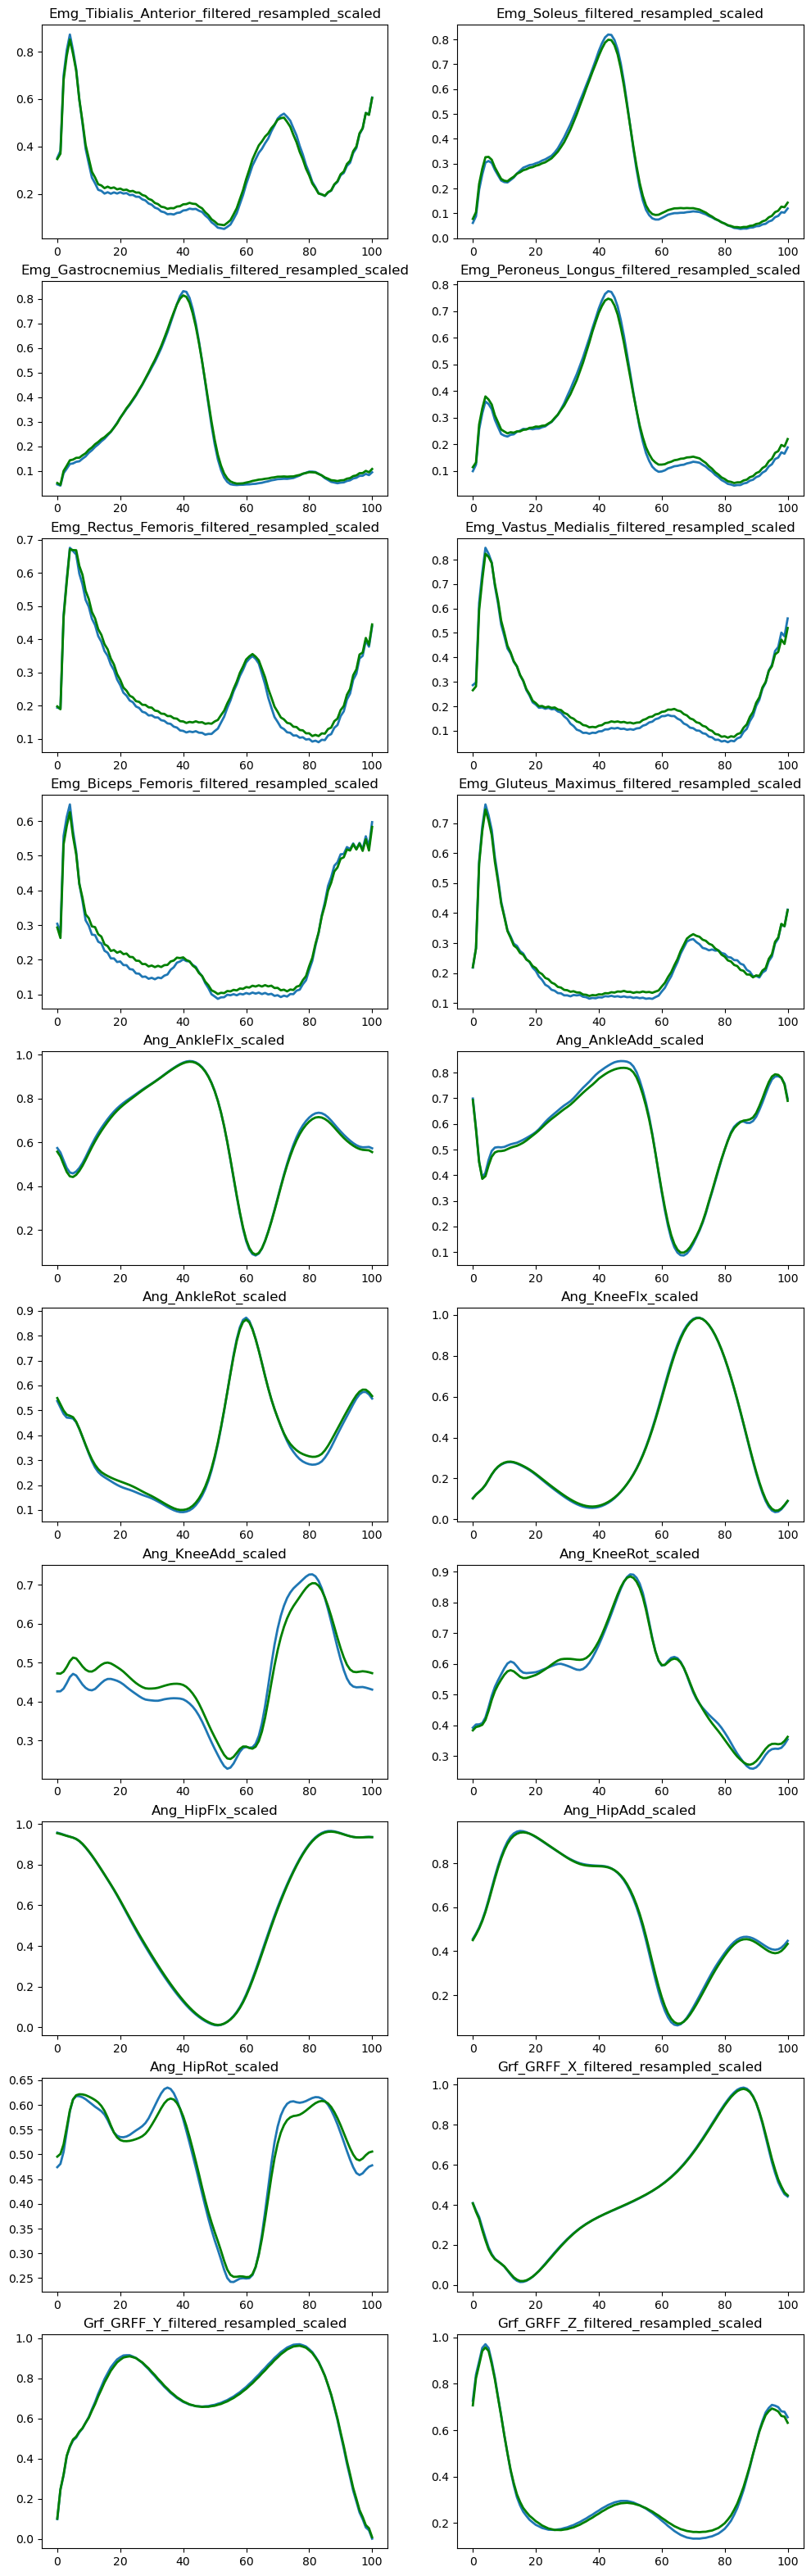

In [99]:
# plot means before and after outlier removal
fig, axes = plt.subplots(ncols=2, nrows=10, figsize=(12, 40))
for check_col, ax in enumerate(axes.flat):

    df_tmp = pd.DataFrame(columns=range(0, 101))
    for i,idx in enumerate(data_selected_clean.index):
        df_tmp.loc[i, :] = data_selected_clean.loc[idx][check_outlier_cols[check_col]]

    smooth_path = df_tmp.mean(axis=0).astype(float)
    path_deviation = df_tmp.std(axis=0).astype(float)
    standard_deviations = 3

    under_line = (smooth_path - standard_deviations * path_deviation)
    over_line = (smooth_path + standard_deviations * path_deviation)

    ax.plot(smooth_path, linewidth=2) #mean curve.
    ax.plot(df_stats.loc[check_outlier_cols[check_col],'mean'][0], color='g', linewidth=2) #mean curve.
    #ax.fill_between(path_deviation.index, under_line, over_line, color='b', alpha=.1) #std curves.
    ax.set_title(check_outlier_cols[check_col])

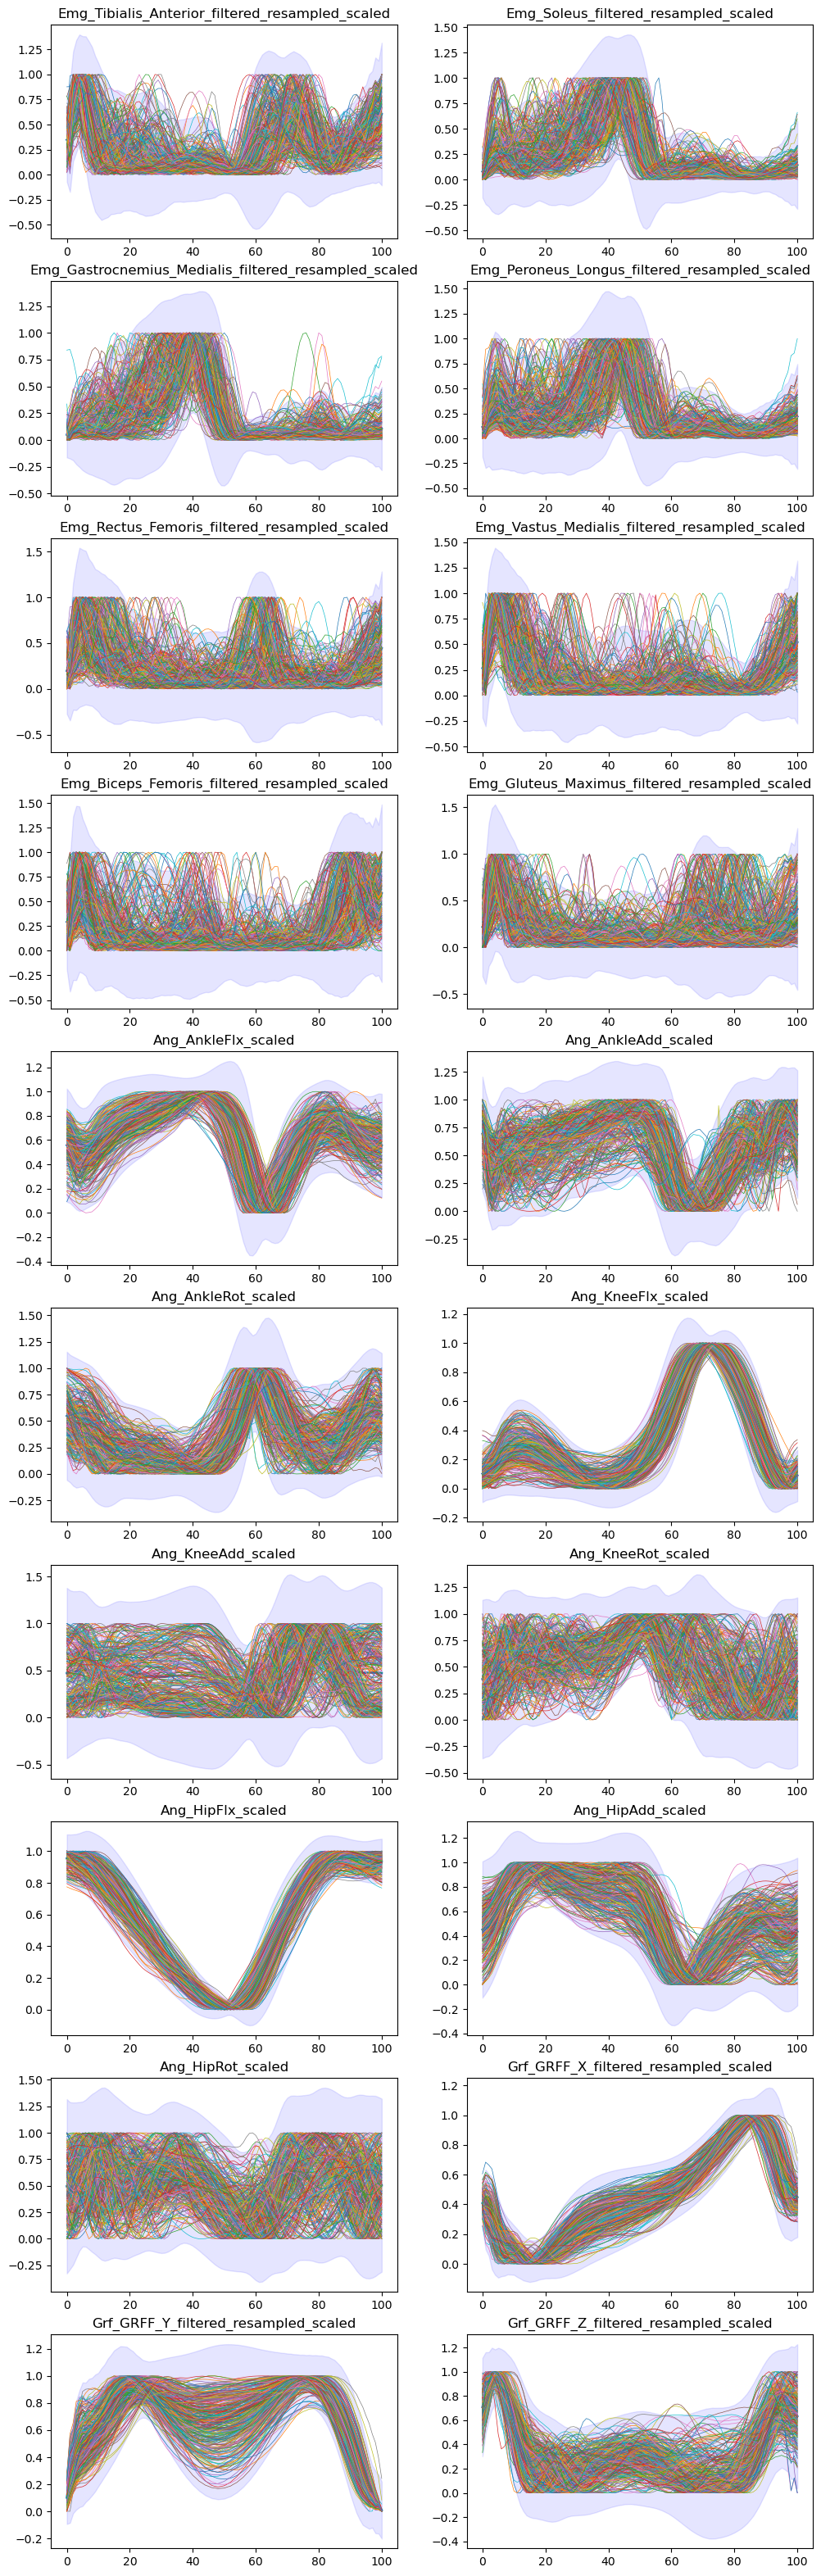

In [101]:
fig, axes = plt.subplots(ncols=2, nrows=10, figsize=(12, 40))
df_min_max = pd.DataFrame(columns=['column','minval','maxval'])
for check_col, ax in enumerate(axes.flat):

    df_tmp = pd.DataFrame(columns=range(0, 101))
    for i,idx in enumerate(data_selected_clean.index):
        df_tmp.loc[i, :] = data_selected_clean.loc[idx][check_outlier_cols[check_col]]

    # smooth_path = df_tmp.mean(axis=0).astype(float)
    # path_deviation = df_tmp.std(axis=0).astype(float)
    standard_deviations = 3
    smooth_path = df_stats.loc[check_outlier_cols[check_col],'mean'][0]
    path_deviation = df_stats.loc[check_outlier_cols[check_col],'std'][0]

    under_line = (smooth_path - standard_deviations * path_deviation)
    over_line = (smooth_path + standard_deviations * path_deviation)

    ax.plot(smooth_path, linewidth=2) #mean curve.
    ax.fill_between(path_deviation.index, under_line, over_line, color='b', alpha=.1) #std curves.

    df_min = df_tmp.min().min()
    df_max = df_tmp.max().max()

    df_min_max.loc[check_col,'column'] = check_outlier_cols[check_col]
    df_min_max.loc[check_col,'minval'] = df_min
    df_min_max.loc[check_col,'maxval'] = df_max

for ii in data_selected_clean.index:
    for i, ax in enumerate(axes.flat):
        y = data_selected_clean.loc[ii, check_outlier_cols[i]]
        df_min = df_min_max[df_min_max.column==check_outlier_cols[i]]['minval'].values
        df_max = df_min_max[df_min_max.column==check_outlier_cols[i]]['maxval'].values
        #y1 = (y-df_min)/(df_max-df_min)
        #ax.plot(y1, linewidth=.5) #mean curve.
        ax.plot(y, linewidth=.5) #mean curve.
        ax.set_title(check_outlier_cols[i])


In [104]:
data_selected = data_selected_clean.copy()
print(len(data_selected.SubjID.unique()))
data_selected.shape

33


(304, 105)

# Select Data

In [103]:
in_cols = emg_cols + ang_cols
out_cols = grf_cols
print('inputs: ',len(in_cols), ' columns')
print(in_cols)
print('outputs: ',len(out_cols), ' columns')
print(out_cols)

inputs:  17  columns
['Emg_Tibialis_Anterior_filtered_resampled_scaled', 'Emg_Soleus_filtered_resampled_scaled', 'Emg_Gastrocnemius_Medialis_filtered_resampled_scaled', 'Emg_Peroneus_Longus_filtered_resampled_scaled', 'Emg_Rectus_Femoris_filtered_resampled_scaled', 'Emg_Vastus_Medialis_filtered_resampled_scaled', 'Emg_Biceps_Femoris_filtered_resampled_scaled', 'Emg_Gluteus_Maximus_filtered_resampled_scaled', 'Ang_AnkleFlx_scaled', 'Ang_AnkleAdd_scaled', 'Ang_AnkleRot_scaled', 'Ang_KneeFlx_scaled', 'Ang_KneeAdd_scaled', 'Ang_KneeRot_scaled', 'Ang_HipFlx_scaled', 'Ang_HipAdd_scaled', 'Ang_HipRot_scaled']
outputs:  3  columns
['Grf_GRFF_X_filtered_resampled_scaled', 'Grf_GRFF_Y_filtered_resampled_scaled', 'Grf_GRFF_Z_filtered_resampled_scaled']


In [105]:
data_training = data_selected[info_columns+in_cols+out_cols]
#data_training.reset_index(inplace=True, drop=True)
data_training

SubjID Gender  Age   BH  BM  \
0     Subject37      F   13  161  47   
2     Subject37      F   13  161  47   
3     Subject37      F   13  161  47   
4     Subject37      F   13  161  47   
5     Subject37      F   13  161  47   
...         ...    ...  ...  ...  ..   
1586  Subject12      F   26  166  54   
1595  Subject12      F   26  166  54   
1596  Subject12      F   26  166  54   
1597  Subject12      F   26  166  54   
1598  Subject12      F   26  166  54   

        Emg_Tibialis_Anterior_filtered_resampled_scaled  \
0     [0.37232878184154217, 0.2978704364384293, 0.57...   
2     [0.502902406511574, 0.5805514985506889, 0.8649...   
3     [0.35620178674018615, 0.37451587671333425, 0.7...   
4     [0.4502251833398026, 0.515568368275494, 0.8525...   
5     [0.7793593823228018, 0.8795416852476995, 0.925...   
...                                                 ...   
1586  [0.3022013618922183, 0.1682283221948858, 0.443...   
1595  [0.21634688789370138, 0.45766210894257586, 0.9...   
1596  [0.3135277486960993, 0.17017336966094343, 0.47...   
1597  [0.5390597029427775, 0.7907789853365461, 0.913...   
1598  [0.14662133091404125, 0.35500573393068463, 0.6...   

                   Emg_Soleus_filtered_resampled_scaled  \
0     [0.07578056231378574, 0.11289526898156882, 0.1...   
2     [0.10135772854639113, 0.08743884833282449, 0.1...   
3     [0.05167980109680769, 0.043177701939775374, 0....   
4     [0.11759895454055327, 0.02465015551701761, 0.1...   
5     [0.06184925655471213, 0.04331393348039894, 0.1...   
...                                                 ...   
1586  [0.024469865026863435, 0.04850363282465954, 0....   
1595  [0.002429999302994229, 0.014596906182222438, 0...   
1596  [0.026265805218441865, 0.06744090895092418, 0....   
1597  [0.038160443628048726, 0.14248700618744908, 0....   
1598  [0.0110025693994808, 0.03551463385705181, 0.15...   

     Emg_Gastrocnemius_Medialis_filtered_resampled_scaled  \
0     [0.007343879636044078, 0.00025075563804643174,...     
2     [0.010054367233035159, 0.013089290941226305, 0...     
3     [0.003884351784367787, 0.0031984655101897352, ...     
4     [0.014339314128836161, 0.01018398117437181, 0....     
5     [0.013642105932252529, 0.0, 0.0369024231095303...     
...                                                 ...     
1586  [0.15079713282912816, 0.0, 0.0775689993541371,...     
1595  [0.006478704253332836, 0.0, 0.0236500714773459...     
1596  [0.0012459100389257821, 0.0, 0.062812993496473...     
1597  [0.007765842863832036, 0.010975713173281824, 0...     
1598  [0.03288820890127969, 0.029195676372806397, 0....     

          Emg_Peroneus_Longus_filtered_resampled_scaled  \
0     [0.010770807338333632, 0.03263172099284144, 0....   
2     [0.13970975740685238, 0.20846481123568825, 0.3...   
3     [0.23978177494006292, 0.1995884627641793, 0.28...   
4     [0.27134367990994124, 0.32913921179168004, 0.5...   
5     [0.19912936742641812, 0.22209305917579036, 0.2...   
...                                                 ...   
1586  [0.08927164810421093, 0.038798231306254, 0.178...   
1595  [0.0, 0.005433258773960253, 0.1475161716650977...   
1596  [0.05879360506610068, 0.04804138843950481, 0.1...   
1597  [0.0871597398171983, 0.14863509420674817, 0.19...   
1598  [0.027621780427410203, 0.06511733691548435, 0....   

           Emg_Rectus_Femoris_filtered_resampled_scaled  ...  \
0     [0.2393561539323546, 0.34859469598879206, 0.34...  ...   
2     [0.3023419340692989, 0.045698354793894336, 0.5...  ...   
3     [0.16364388883585082, 0.23392576558938769, 0.3...  ...   
4     [0.6030809224067402, 0.6322948681831524, 0.833...  ...   
5     [0.0582569918841289, 0.016644969416067606, 0.1...  ...   
...                                                 ...  ...   
1586  [0.09095679928024486, 0.2312652312347476, 0.45...  ...   
1595  [0.0, 0.14809930521327763, 0.8199356310638235,...  ...   
1596  [0.1616238339540349, 0.17773549896413765, 0.70...  ...   
1597  [0.31712087350761703, 

# Training

In [106]:
class PrepareData(torch.utils.data.Dataset):
    def __init__(self, data_in_df, input_cols, output_cols):
        for idx, (_, row) in enumerate(data_in_df.iterrows()):
            data_seq_len = row[input_cols[0]].shape[0]
            Xt = np.vstack((row[input_cols])).T.reshape(1,data_seq_len,len(input_cols))
            #Xt = np.vstack((row[input_cols])).T.reshape(1,101,len(input_cols))
            Yt = np.vstack((row[output_cols])).T.reshape(1,data_seq_len,len(output_cols))
            if idx == 0:
                X = Xt
                y = Yt
            else:
                X = np.vstack((X,Xt)).astype(float)
                y = np.vstack((y,Yt)).astype(float)

        #X = pd.DataFrame(data_in_df['emg'].values.tolist()).values
        #y = pd.DataFrame(data_in_df[output_cols].values.tolist()).values
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X)
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [107]:
# Create RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()

        # Number of hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # RNN
        #self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu', dropout=0.5)
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=0.5)
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)



    def forward(self, x):

        # Initialize hidden state with zeros: no need it is automatic
        #h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        #out, hn = self.rnn(x, h0)

        # One time step
        out, hn = self.rnn(x)
        #out = self.fc(out[:, -1, :])
        out = self.fc(out)

        return out


In [108]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self,yhat,y):
        loss_ = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss_

In [109]:
subjects = data_training.SubjID.unique()
subjects_train, subjects_test = train_test_split(subjects, test_size=0.15, random_state=42)
subjects_train, subjects_valid = train_test_split(subjects_train, test_size=0.15, random_state=42)
train_df = data_training[data_training.SubjID.isin(subjects_train)]
test_df = data_training[data_training.SubjID.isin(subjects_test)]
valid_df = data_training[data_training.SubjID.isin(subjects_valid)]
len(subjects_train), len(train_df), len(subjects_test), len(test_df), len(subjects_valid), len(valid_df)

(23, 211, 5, 53, 5, 40)

In [110]:
# Train and evaluate the accuarcy of neural network model
def train_and_evaluate(param, model):
    ds_train = PrepareData(train_df, in_cols, out_cols)
    trainloader = DataLoader(ds_train, batch_size=8, shuffle=True, drop_last=True)

    ds_valid = PrepareData(valid_df, in_cols, out_cols)
    validloader = DataLoader(ds_valid, batch_size=8, shuffle=True, drop_last=True)

    #criterion = nn.L1Loss()
    criterion = nn.MSELoss()
    #criterion = RMSELoss()

    #optimizer = torch.optim.Adam(model.parameters(), lr=param['learning_rate'])
    optimizer = torch.optim.Adam(model.parameters(), lr=param['learning_rate'], weight_decay=param['weight_decay'])
    #optimizer = getattr(torch.optim, param["optimizer"])(model.parameters(), lr=param['learning_rate'], weight_decay=param['weight_decay'])
    #scheduler = lr_scheduler.StepLR(optimizer,
    #                   step_size = 4, # Period of learning rate decay
    #                   gamma = 0.5) # Multiplicative factor of learning rate decay
    #scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=30)
    #scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    # Run the training loop
    loss_list = []
    for epoch in range(0, 300): # 5 epochs at maximum
        train_loss = 0.0
        model.train()
        for data, labels in trainloader:
            data, labels = data.float(), labels.float()

            # Transfer Data to GPU if available
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()

            # Clear the gradients
            optimizer.zero_grad()
            # Forward Pass
            outputs = model(data)
            # Find the Loss
            loss = criterion(outputs,labels)
            # Calculate gradients
            loss.backward()
            # Update Weights
            optimizer.step()
            # Calculate Loss
            train_loss += loss.item()

        #scheduler.step()

        valid_corr = 0.0
        valid_loss = 0.0
        model.eval()	 # Optional when not using Model Specific layer
        for data, labels in validloader:
            data, labels = data.float(), labels.float()

            # Transfer Data to GPU if available
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()

            with torch.no_grad():
                # Forward Pass
                outputs = model(data)
            # Find the Loss
            loss = criterion(outputs,labels)
            # Calculate Loss
            valid_loss += loss.item()

            #valid_corr += torch.corrcoef(torch.vstack((outputs[:,0],labels[:,0])))[0,1]
            valid_corr += (torch.corrcoef(torch.vstack((outputs[:,0],labels[:,0])))[0,1]+
                           torch.corrcoef(torch.vstack((outputs[:,1],labels[:,1])))[0,1]+
                           torch.corrcoef(torch.vstack((outputs[:,2],labels[:,2])))[0,1])/3

        total_loss = valid_loss/len(validloader)
        total_corr = valid_corr/len(validloader)
        loss_list.append([train_loss/len(trainloader) ,total_loss])

    return model, total_loss, loss_list
    #return model, total_loss, total_corr

In [111]:
# Define a set of hyperparameter values, build the model, train the model, and evaluate the accuracy
def objective(trial):

    params = {
        #'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'learning_rate': trial.suggest_categorical('learning_rate', [1e-5,5e-5,1e-4,5e-4,1e-3,5e-3,1e-2]),
        #'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
        #'n_unit': trial.suggest_int("n_unit", 4, 18),
        'weight_decay': trial.suggest_categorical("weight_decay", [1e-4,1e-3,1e-2]),
        'hidden_dim': trial.suggest_int("hidden_dim", 3, 50),
        #'layer_dim': trial.suggest_int("layer_dim", 2, 5)
        'layer_dim': trial.suggest_int("layer_dim", 1, 4)
    }

    input_dim = len(in_cols)    # input dimension
    output_dim = len(out_cols)   # output dimension
    hidden_dim = params['hidden_dim']
    layer_dim = params['layer_dim']

    model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)
    if torch.cuda.is_available():
        model = model.cuda()

    #model = build_model(params)

    _, total_loss, _ = train_and_evaluate(params, model)
    #_, total_loss, total_corr = train_and_evaluate(params, model)

    return total_loss
    #return total_loss, total_corr

In [112]:
#EPOCHS = 30
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
# study = optuna.create_study(directions=["minimize", "maximize"], sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=1)

[I 2023-09-29 11:55:41,001] A new study created in memory with name: no-name-36d04003-6f05-40e0-8213-1225c671dd4c
[I 2023-09-29 12:04:25,854] Trial 0 finished with value: 0.07634224146604537 and parameters: {'learning_rate': 0.0005, 'weight_decay': 0.01, 'hidden_dim': 15, 'layer_dim': 4}. Best is trial 0 with value: 0.07634224146604537.


In [113]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0       0  0.076342 2023-09-29 11:55:41.013427 2023-09-29 12:04:25.854118   

                duration  params_hidden_dim  params_layer_dim  \
0 0 days 00:08:44.840691                 15                 4   

   params_learning_rate  params_weight_decay     state  
0                0.0005                 0.01  COMPLETE

In [114]:
#best_trial = study.best_trial
best_trial = study.best_trials[0]

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

learning_rate: 0.0005
weight_decay: 0.01
hidden_dim: 15
layer_dim: 4


In [115]:
def train_best_model(params):

    input_dim = len(in_cols)    # input dimension
    output_dim = len(out_cols)   # output dimension
    hidden_dim = params['hidden_dim']
    layer_dim = params['layer_dim']

    model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)
    if torch.cuda.is_available():
        model = model.cuda()

    #model = build_model(params)

    model_, _, losses_ = train_and_evaluate(params, model)
    #model, _, _ = train_and_evaluate(params, model)

    return model_, losses_

In [117]:
model, losses = train_best_model(best_trial.params)

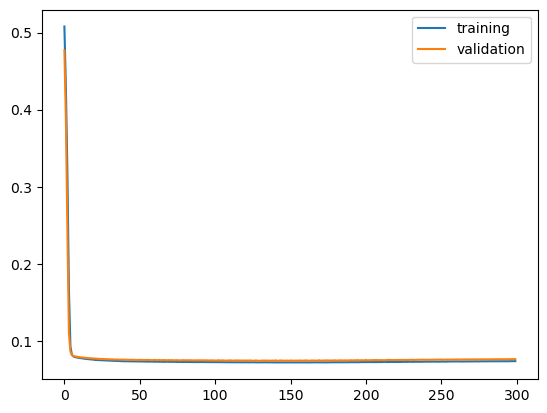

In [118]:
losses = np.asarray(losses)
plt.plot(losses[:,0])
plt.plot(losses[:,1])
plt.legend(['training','validation']);

# Testing

In [119]:
emg_cols1 = [c for c in data_selected.columns if (('Emg_' in c) and not('_filtered' in c))]
ang_cols1 = [c for c in data_selected.columns if (('Ang_Ankle' in c) and not('_scaled' in c))] \
           + [c for c in data_selected.columns if (('Ang_Knee' in c) and not('_scaled' in c))] \
           + [c for c in data_selected.columns if (('Ang_Hip' in c) and not('_scaled' in c))]
grf_cols1 = [c for c in data_selected.columns if (('Grf_GRFF' in c) and not('_filtered' in c))]
check_outlier_cols1 = emg_cols1 + ang_cols1 + grf_cols1 + info_columns
check_outlier_cols1

['Emg_Tibialis_Anterior',
 'Emg_Soleus',
 'Emg_Gastrocnemius_Medialis',
 'Emg_Peroneus_Longus',
 'Emg_Rectus_Femoris',
 'Emg_Vastus_Medialis',
 'Emg_Biceps_Femoris',
 'Emg_Gluteus_Maximus',
 'Ang_AnkleFlx',
 'Ang_AnkleAdd',
 'Ang_AnkleRot',
 'Ang_KneeFlx',
 'Ang_KneeAdd',
 'Ang_KneeRot',
 'Ang_HipFlx',
 'Ang_HipAdd',
 'Ang_HipRot',
 'Grf_GRFF_X',
 'Grf_GRFF_Y',
 'Grf_GRFF_Z',
 'SubjID',
 'Gender',
 'Age',
 'BH',
 'BM']

In [120]:
data_selected_before_preprocess = data_selected_clean[check_outlier_cols1].copy()

In [121]:
test_df

SubjID Gender  Age   BH  BM  \
480   Subject27      M   16  180  62   
481   Subject27      M   16  180  62   
482   Subject27      M   16  180  62   
483   Subject27      M   16  180  62   
484   Subject27      M   16  180  62   
485   Subject27      M   16  180  62   
487   Subject27      M   16  180  62   
488   Subject27      M   16  180  62   
489   Subject27      M   16  180  62   
490   Subject27      M   16  180  62   
491   Subject27      M   16  180  62   
492   Subject27      M   16  180  62   
493   Subject27      M   16  180  62   
494   Subject27      M   16  180  62   
853   Subject50      F   25  159  62   
854   Subject50      F   25  159  62   
855   Subject50      F   25  159  62   
857   Subject50      F   25  159  62   
861   Subject50      F   25  159  62   
868   Subject50      F   25  159  62   
943   Subject48      M   37  170  73   
947   Subject48      M   37  170  73   
948   Subject48      M   37  170  73   
950   Subject48      M   37  170  73   
956   Subject48      M   37  170  73   
957   Subject48      M   37  170  73   
1347  Subject14      M   35  176  74   
1348  Subject14      M   35  176  74   
1349  Subject14      M   35  176  74   
1350  Subject14      M   35  176  74   
1351  Subject14      M   35  176  74   
1352  Subject14      M   35  176  74   
1353  Subject14      M   35  176  74   
1354  Subject14      M   35  176  74   
1355  Subject14      M   35  176  74   
1492  Subject11      M   45  187  69   
1494  Subject11      M   45  187  69   
1497  Subject11      M   45  187  69   
1501  Subject11      M   45  187  69   
1503  Subject11      M   45  187  69   
1505  Subject11      M   45  187  69   
1507  Subject11      M   45  187  69   
1509  Subject11      M   45  187  69   
1511  Subject11      M   45  187  69   
1513  Subject11      M   45  187  69   
1515  Subject11      M   45  187  69   
1517  Subject11      M   45  187  69   
1521  Subject11      M   45  187  69   
1523  Subject11      M   45  187  69   
1525  Subject11      M   45  187  69   
1527  Subject11      M   45  187  69   
1528  Subject11      M   45  187  69   
1529  Subject11      M   45  187  69   

        Emg_Tibialis_Anterior_filtered_resampled_scaled  \
480   [0.23105847360536969, 0.39670631095787406, 0.8...   
481   [0.5719269409111769, 0.7709917672745543, 0.920...   
482   [0.36557583696563767, 0.32562657743544887, 0.8...   
483   [0.3434662334330424, 0.30596450401112957, 0.72...   
484   [0.6839249373559022, 0.6412384241757687, 0.935...   
485   [0.3164567539483348, 0.5124518423822848, 0.907...   
487   [0.4218246589968034, 0.4395887002452058, 0.735...   
488   [0.404613381058332, 0.25307934271170246, 0.649...   
489   [0.6532385666061865, 0.7581322558656615, 0.988...   
490   [0.2940784011554851, 0.3814116493266066, 0.801...   
491   [0.4934347104283884, 0.47673870400973484, 0.82...   
492   [0.19025839382497656, 0.2434977244541529, 0.93...   
493   [0.2538484382847708, 0.3878648248043897, 0.799...   
494   [0.3182300793264318, 0.3372006088680806, 0.753...   
853   [0.1521394557931962, 0.1782393074130424, 0.328...   
854   [0.2625088515350232, 0.3858228159587633, 0.595...   
855   [0.1625440625955507, 0.41914764711380487, 0.73...   
857   [0.32849493550325604, 0.2648541844446404, 0.64...   
861   [0.3357610834486463, 0.5930695050269074, 0.878...   
868   [0.30053155173644525, 0.30187294092480044, 0.7...   
943   [0.34887068182721415, 0.5270683291962075, 0.85...   
947   [0.3834798416672779, 0.25367812790466515, 0.64...   
948   [0.43794623338855293, 0.47110067370353015, 0.8...   
950   [0.5820920449632935, 0.5581155583997024, 0.772...   
956   [0.540114589727445, 0.3788170242720671, 0.7175...   
957   [0.4311633307372351, 0.3225767601850682, 0.857...   
1347  [0.3633276025772684, 0.5885584134320957, 0.771...   
1348  [0.210248699140067, 0.24760450748877505, 0.522...   
1349  [0.38553931618194937, 0.21179895726712042, 0.4...   
1350  [0.3642092022947948, 0.6343650719024658, 0.814...   
1351  [0.1279845786

In [295]:
def rmse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Mean Squared Error """
    return np.sqrt(np.mean(np.square(actual - predicted)))

def nrmse(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Root Mean Squared Error """
    return rmse(actual, predicted) / (actual.max() - actual.min())

def calculate_metrics(reference_data_scaled, reference_data_filtered_resampled, true_data, prediction_data):
    if np.all(np.round(reference_data_scaled,3) == np.round(true_data,3)):
        grf_max=reference_data_filtered_resampled.max()
        grf_min=reference_data_filtered_resampled.min()
        x_pred = minmax_scale(prediction_data, feature_range=(grf_min, grf_max))
        x_true = reference_data_filtered_resampled
        # plt.plot(x_true)
        # plt.plot(x_pred)
        return rmse(x_true, x_pred), nrmse(x_true, x_pred), np.corrcoef(x_true,x_pred)[0,1], x_pred
    else:
        return np.nan, np.nan, np.nan, np.nan


In [296]:
ds_test = PrepareData(test_df, in_cols, out_cols)

df_results = pd.DataFrame()
input_dim = len(in_cols)
for idx,(data, labels) in enumerate(ds_test):
    #data, labels = data.reshape(101, input_dim).float(), labels.reshape(101,1).float()
    data, labels = data.float(), labels.float()

    # Transfer Data to GPU if available
    if torch.cuda.is_available():
        data, labels = data.cuda(), labels.cuda()

    with torch.no_grad():
        # Forward Pass
        outputs = model(data)

    labels=labels.detach().cpu().numpy()
    outputs=outputs.detach().cpu().numpy()

    df_results_temp = pd.DataFrame()
    df_results_temp['label'] = [labels]
    df_results_temp['outputs'] = [outputs]

    # to guarantee test dataset is not shuffled
    test_idx = test_df.index[idx]

    ref_scaled = data_selected.loc[test_idx,'Grf_GRFF_X_filtered_resampled_scaled']
    ref_filtered_resampled = data_selected.loc[test_idx,'Grf_GRFF_X_filtered_resampled']
    label_sig = labels[:,0]
    prediction_sig = outputs[:,0]

    out_metrics = calculate_metrics(ref_scaled, ref_filtered_resampled, label_sig, prediction_sig)

    df_results_temp['rmse_x']  = out_metrics[0]
    df_results_temp['nrmse_x'] = out_metrics[1]
    df_results_temp['corr_x']  = out_metrics[2]
    df_results_temp['pred_x_rescaled']  = out_metrics[3]

    df_results = pd.concat([df_results, df_results_temp], axis=0, ignore_index=True)

#df_results['rmse'].hist()
#df_results

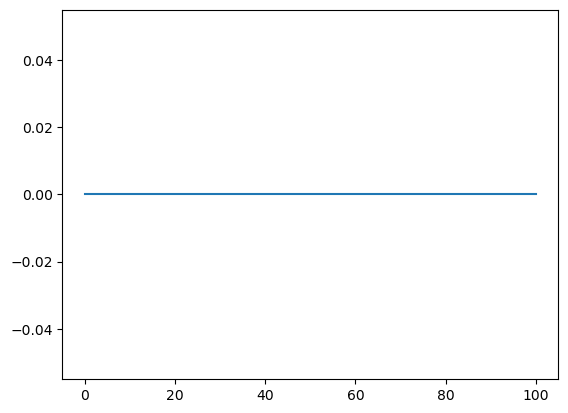

In [292]:
y = data_selected.loc[test_idx,'Grf_GRFF_X']
y = moving_average(y, window_size=30)
y = signal.resample(y, 101)
y = minmax_scale(y, feature_range=(0, 1))

plt.plot(y-data_selected.loc[test_idx,'Grf_GRFF_X_filtered_resampled_scaled'])

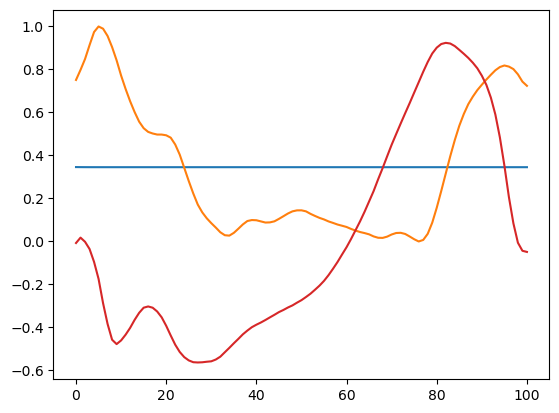

In [297]:
plt.plot(outputs[:,2])
plt.plot(labels[:,2])
plt.plot(out_metrics[3])
plt.plot(ref_filtered_resampled)

In [124]:
#df_results[['rmse','loss','corr','rmse_x','rmse_y','rmse_z','corr_x','corr_y','corr_z']].describe()
df_results[['rmse_x','rmse_y','rmse_z','corr_x','corr_y','corr_z']].describe()

rmse_x     rmse_y     rmse_z     corr_x     corr_y     corr_z
count  53.000000  53.000000  53.000000  53.000000  53.000000  53.000000
mean    0.999276   2.855576   0.243046   0.038396   0.369478   0.315125
std     0.274969   0.178357   0.049970   0.021472   0.045839   0.050378
min     0.492176   2.506722   0.137298  -0.017172   0.203915   0.210426
25%     0.778775   2.709090   0.201959   0.026417   0.358355   0.279161
50%     1.019453   2.861404   0.239904   0.039804   0.377199   0.314903
75%     1.186204   2.988587   0.285351   0.051197   0.400507   0.344458
max     1.629424   3.214993   0.332882   0.080484   0.461529   0.428988

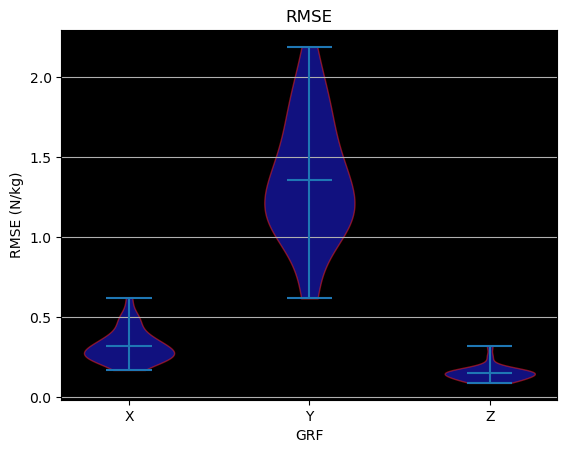

In [55]:
#ax = df.plot.bar(rot=0)
#df_results[['rmse_x','rmse_y','rmse_z']].plot.box(rot=0)

fig, axes = plt.subplots()

violin_parts = axes.violinplot(dataset = df_results[['rmse_x','rmse_y','rmse_z']],
                showmeans = True)
axes.set_facecolor('black')

axes.set_title('RMSE')
axes.yaxis.grid(True)
axes.set_xlabel('GRF')
axes.set_ylabel('RMSE (N/kg)')
axes.set_xticks([1,2,3])
axes.set_xticklabels(['X','Y','Z'])

rrred = '#ff2222'
bluuu = '#2222ff'
for vp in violin_parts['bodies']:
    vp.set_facecolor(bluuu)
    vp.set_edgecolor(rrred)
    vp.set_linewidth(1)
    vp.set_alpha(0.5)

plt.show()

In [56]:
if all([all(test_df.iloc[i][out_cols[0]].astype('float32') == df_results.loc[i,'label'][:,0]) for i in range(len(df_results))]):
    df_results.index = test_df.index
    df_results = pd.merge(test_df[info_columns+[out_cols[0]]],df_results, left_index=True, right_index=True)
    print('info DF is merged')
else:
    print('Something wrong, could not merged!!!')
df_results

info DF is merged


SubjID Gender  Age   BH  BM  \
2    Subject37      F   13  161  47   
3    Subject37      F   13  161  47   
4    Subject37      F   13  161  47   
5    Subject37      F   13  161  47   
7    Subject37      F   13  161  47   
49   Subject22      M   32  174  71   
51   Subject22      M   32  174  71   
52   Subject22      M   32  174  71   
54   Subject22      M   32  174  71   
56   Subject22      M   32  174  71   
58   Subject22      M   32  174  71   
60   Subject22      M   32  174  71   
62   Subject22      M   32  174  71   
64   Subject22      M   32  174  71   
66   Subject22      M   32  174  71   
68   Subject22      M   32  174  71   
70   Subject22      M   32  174  71   
72   Subject22      M   32  174  71   
74   Subject22      M   32  174  71   
76   Subject22      M   32  174  71   
78   Subject22      M   32  174  71   
81   Subject22      M   32  174  71   
513  Subject33      M   12  147  30   
514  Subject33      M   12  147  30   
518  Subject33      M   12  147  30   
522  Subject33      M   12  147  30   
525  Subject33      M   12  147  30   
527  Subject33      M   12  147  30   
530  Subject33      M   12  147  30   

                  Grf_GRFF_X_filtered_resampled_scaled  \
2    [0.4051720145395559, 0.40985511133724, 0.38123...   
3    [0.45052003292242754, 0.41876484061571595, 0.3...   
4    [0.34788999515204455, 0.317248785537578, 0.283...   
5    [0.3771818195325464, 0.3686168723857787, 0.329...   
7    [0.5347981271325073, 0.5196311605506544, 0.482...   
49   [0.4309550252172289, 0.36670534521060505, 0.34...   
51   [0.46303422703587105, 0.41001597089140307, 0.3...   
52   [0.4194374757534174, 0.3487277840343891, 0.327...   
54   [0.4111139425445688, 0.3612033304562613, 0.339...   
56   [0.4455929160739232, 0.3735895279022427, 0.347...   
58   [0.4166043141128919, 0.4096949478915951, 0.394...   
60   [0.41228757436371716, 0.40198451392755896, 0.3...   
62   [0.41885589660001804, 0.43053376573367674, 0.4...   
64   [0.42515474142780063, 0.4565971171214314, 0.44...   
66   [0.39448765985215534, 0.41358428529427516, 0.4...   
68   [0.4237725811536832, 0.4195121468369382, 0.407...   
70   [0.4362310804361821, 0.4234909776528957, 0.401...   
72   [0.3891571439975375, 0.37445308554477047, 0.35...   
74   [0.42807954299616485, 0.4006152903687175, 0.38...   
76   [0.4124354542550457, 0.3923346592731596, 0.372...   
78   [0.4025519115997548, 0.46138939512953775, 0.44...   
81   [0.44883339543803213, 0.4928482436605512, 0.47...   
513  [0.4233274146378916, 0.3234700196521073, 0.292...   
514  [0.49383337504499203, 0.3966424265434162, 0.37...   
518  [0.3591913712280844, 0.2821403044874319, 0.260...   
522  [0.48379342907290973, 0.4083388798014651, 0.37...   
525  [0.44156774892483264, 0.3993959959524912, 0.37...   
527  [0.5122555770088336, 0.4328266013138102, 0.412...   
530  [0.4287095650853822, 0.3076102882141657, 0.293...   

                                                 label  \
2    [[0.40517202, 0.047825474, 0.86632717], [0.409...   
3    [[0.45052004, 0.042646185, 0.93373615], [0.418...   
4    [[0.34789, 0.06312874, 0.91168463], [0.3172488...   
5    [[0.37718183, 0.086363934, 0.87903047], [0.368...   
7    [[0.53479815, 0.008899184, 0.8686226], [0.5196...   
49   [[0.43095502, 0.105830394, 0.6230745], [0.3667...   
51   [[0.4630342, 0.09767941, 0.6989213], [0.410015...   
52   [[0.41943747, 0.11331172, 0.7842321], [0.34872...   
54   [[0.41111395, 0.07992888, 0.6364332], [0.36120...   
56   [[0.4455929, 0.12333271, 0.5763379], [0.373589...   
58   [[0.4166043, 0.05545372, 0.81747603], [0.40969...   
60   [[0.41228756, 0.07514478, 0.8163052], [0.40198...   
62   [[0.4188559, 0.052942406, 0.7783567], [0.43053...   
64   [[0.42515475, 0.041075516, 0.7926987], [0.4565...   
66   [[0.39448765, 0.04439701, 0.81373334], [0.4135...   
68   [[0.42377257, 0.056780465, 0.7689469], [0.4195...   
70   [[0.43623108, 0.07204666, 0.753884], [0.423490...   
72   [[0.38915715, 0.06982153, 0.74873835], [0.3744.

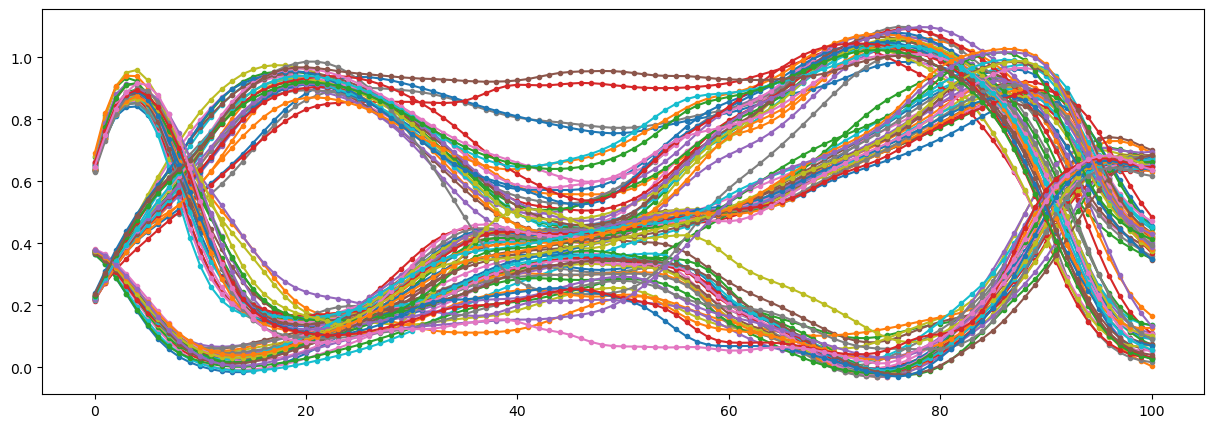

In [57]:
plt.figure(figsize=(15, 5))
for this_index in df_results.index:
    plt.plot(df_results.loc[this_index,'outputs'], '.-')

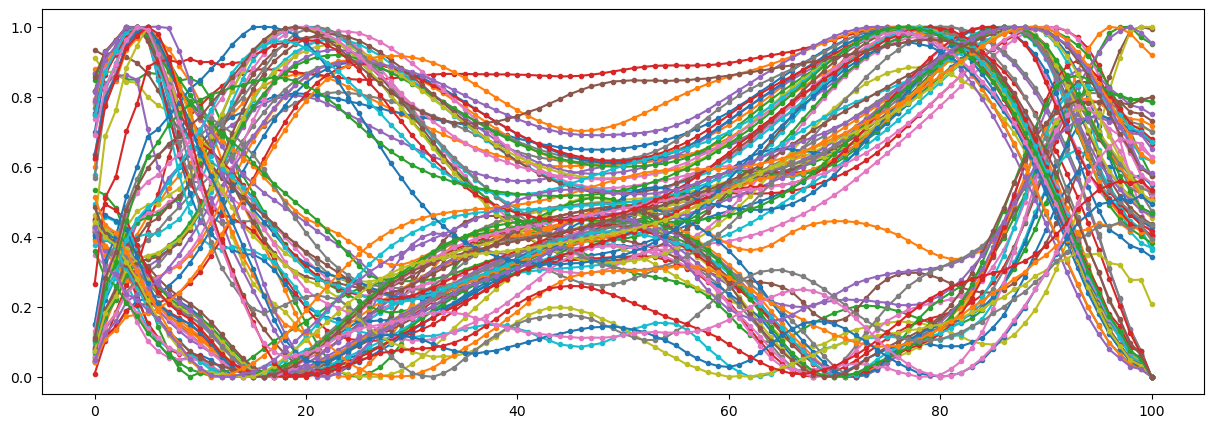

In [58]:
plt.figure(figsize=(15, 5))
for this_index in df_results.index:
    plt.plot(df_results.loc[this_index,'label'], '.-')

In [59]:
def plot_pred(targ, preds):
    plt.figure(figsize=(15, 5))
    plt.plot(targ, '.-', preds, 'o-')
    plt.xlabel('Time, Seconds')
    plt.legend(['target', 'prediction'], loc='best')
    plt.show()

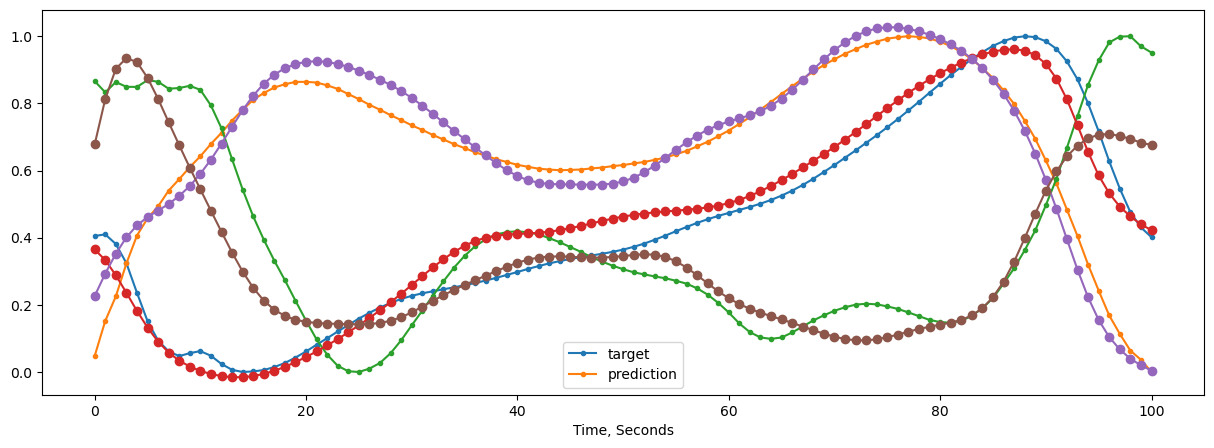

SubjID Gender  Age   BH  BM  \
2  Subject37      F   13  161  47   

                Grf_GRFF_X_filtered_resampled_scaled  \
2  [0.4051720145395559, 0.40985511133724, 0.38123...   

                                               label  \
2  [[0.40517202, 0.047825474, 0.86632717], [0.409...   

                                             outputs    rmse_x    rmse_y  \
2  [[0.36493483, 0.22628886, 0.67806524], [0.3332...  0.249077  0.616892   

     rmse_z    corr_x    corr_y    corr_z  
2  0.087491  0.976064  0.978559  0.925689

In [60]:
#this_index = df_results[df_results['loss'] == df_results['loss'].min()].index[0]
this_index = df_results[df_results['rmse_y'] == df_results['rmse_y'].min()].index[0]
#this_index = df_results[df_results['corr'] == df_results['corr'].max()].index[0]
plot_pred(df_results.loc[this_index,'label'], df_results.loc[this_index,'outputs'])
df_results.loc[this_index:this_index,]

In [72]:
data_selected[data_selected['Grf_GRFF_Z_filtered_resampled_scaled'].apply(lambda x: x[80]>0.6)]

SubjID Foot  TimeStampKin  TimeStampGrf  TimeStampEmg     Task  \
826  Subject44   RX          1.45          1.45          1.45  Walking   

                                                Marker     speed  \
826  [[0.5110120177268982, 0.5195537805557251, 0.52...  1.771842   

     strideLength  stepWidth  ...  \
826      1.503808   0.080872  ...   

                  Grf_GRFF_Z_filtered_resampled_scaled  \
826  [0.6671919852833833, 0.823224125996364, 0.8610...   

                                   Ang_AnkleFlx_scaled  \
826  [0.6658333280155744, 0.6194821329715172, 0.541...   

                                   Ang_AnkleAdd_scaled  \
826  [0.8453981417542987, 0.6877905791292968, 0.500...   

                                   Ang_AnkleRot_scaled  \
826  [0.5847808610246541, 0.5442681203516049, 0.479...   

                                    Ang_KneeFlx_scaled  \
826  [0.056537708903423176, 0.07394677773703255, 0....   

                                    Ang_KneeAdd_scaled  \
826  [0.5099370484720062, 0.5065866497385105, 0.499...   

                                    Ang_KneeRot_scaled  \
826  [0.47479178029123537, 0.4822420324410434, 0.51...   

                                     Ang_HipFlx_scaled  \
826  [0.8357857411927917, 0.8302020947773382, 0.826...   

                                     Ang_HipAdd_scaled  \
826  [0.4440677732888981, 0.4789150568016367, 0.518...   

                                     Ang_HipRot_scaled  
826  [0.5289974290304694, 0.5423503486349598, 0.560...  

[1 rows x 105 columns]

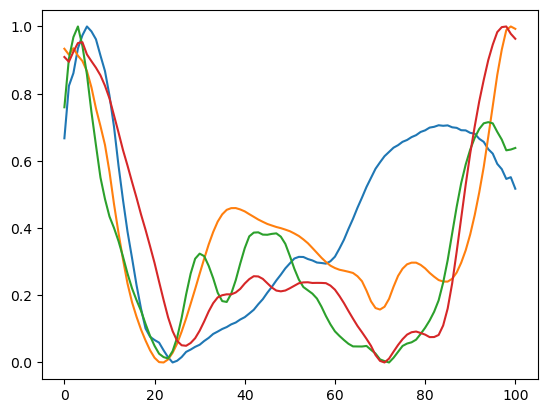

In [85]:
plt.plot(data_selected['Grf_GRFF_Z_filtered_resampled_scaled'][826])
plt.plot(data_selected['Grf_GRFF_Z_filtered_resampled_scaled'][3])
plt.plot(data_selected['Grf_GRFF_Z_filtered_resampled_scaled'][data_selected.index[35]])
plt.plot(data_selected['Grf_GRFF_Z_filtered_resampled_scaled'][data_selected.index[50]])